In [ ]:
!pip install scipy==1.6.3
!pip install scikit_optimize==0.8.1
!pip install scikit_learn==0.24.2
! git clone https://github.com/zykhoo/understandingPINNs.git

     |████████████████████████████████| 27.4 MB 68.6 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
     |████████████████████████████████| 101 kB 4.5 MB/s 
     |████████████████████████████████| 22.3 MB 1.5 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.4 requires scikit-learn>=1.0.0, but 

In [ ]:
import numpy as np

experiment,sys,dim = "NN","LV",2
alpha, beta, delta, gamma = 2/3, 4/3, 1., 1.
f1 = lambda x: alpha * x[0] - beta * x[0] * x[1] #x[1]
f2 = lambda x: delta * x[0] * x[1] - gamma * x[1] #-np.sin(x[0])
H = lambda x: delta * x[0] - gamma * np.log(x[0]) + beta * x[1] - alpha * np.log(x[1]) # 1/2*x[1]**2+(1-np.cos(x[0]))
# spacedim=[(-2*np.pi, 2*np.pi), (-1.2, 1.2)]
spacedim=[(0., 4.), (0., 4.)]
fvector = lambda x: np.asarray([f1(x), f2(x)])
h= 0.1
x0, H0 = 0.,0.
initialcon = [64]
LR=0.001
diagdist = np.sum(np.square(np.asarray([spacedim[0][0], spacedim[0][1]]), np.asarray([spacedim[1][0], spacedim[1][1]])))
epsilon = 0.1

In [ ]:
def classicSympEuler(z,f1,f2,h,maxiters):
	## classical symplectic Euler scheme
	dim = int(len(z)/2)
	q=z[:dim]
	p=z[dim:]
	fstage = lambda stg: h * f1(np.block([q + stg, p]))

	stageold=np.zeros(dim) 
	stage = fstage(stageold) +0.
	Iter = 0

	while (np.amax(abs(stage - stageold)) > 1e-10 and Iter<int(maxiters)):
		stageold = stage+0.
		stage = fstage(stage)+0.
		Iter = Iter+1
	q = q+stage
	p = p + h*f2(np.block([q,p]))
	return np.block([q,p])

def SympEulerTrajectory(z,f1,f2,h,N=10,n_h=1,maxiters=100):
	## trajectory computed with classicInt
  h_gen = h/n_h
  z = z.reshape(1,-1)[0]
  trj = np.zeros((len(z),N+1))
  trj[:,0] = z.copy()

  for i in range(0,N):
    for j in range(0,int(n_h+1)):
      trj[:,i+1] = classicSympEuler(trj[:,i].copy(),f1,f2,h_gen,maxiters)
  return trj[:, :-1], trj[:, 1:]

In [ ]:
euler_traj = SympEulerTrajectory(np.asarray([[0.4],[1.]]),f1,f2,h,N=1000,n_h=1,maxiters=100)

In [ ]:
def classicLeapfrog(z,f1,f2,h):
## classical Leapfrog scheme for force field f
# can compute multiple initial values simultanously, z[k]=list of k-component of all initial values
	dim = int(len(z)/2)
	z[dim:] = z[dim:]+h/2*f2(z)
	z[:dim] = z[:dim]+h*f1(z)
	z[dim:] = z[dim:]+h/2*f2(z)
	return z

def LeapfrogTrajectory(z,f1,f2,h,N=10,n_h=100):
  ## trajectory computed with classicInt
  h_gen = h/n_h
  z = z.reshape(1,-1)[0]
  trj = np.zeros((len(z),N+1))
  trj[:,0] = z.copy()
  for i in range(0,N):
    for j in range(0,int(n_h+1)):
      trj[:,i+1] = classicLeapfrog(trj[:,i].copy(),f1,f2,h_gen)
  return trj[:, :-1], trj[:, 1:]

In [ ]:
leapfrog_traj = LeapfrogTrajectory(np.asarray([[0.4],[1.]]),f1,f2,h,N=1000,n_h=1)

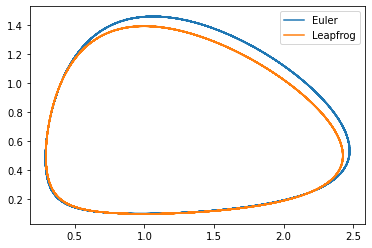

In [ ]:
import matplotlib.pyplot as plt
plt.plot(euler_traj[1][0,:],euler_traj[1][1,:], label = "Euler")
plt.plot(leapfrog_traj[1][0,:],leapfrog_traj[1][1,:], label = "Leapfrog")
plt.legend()